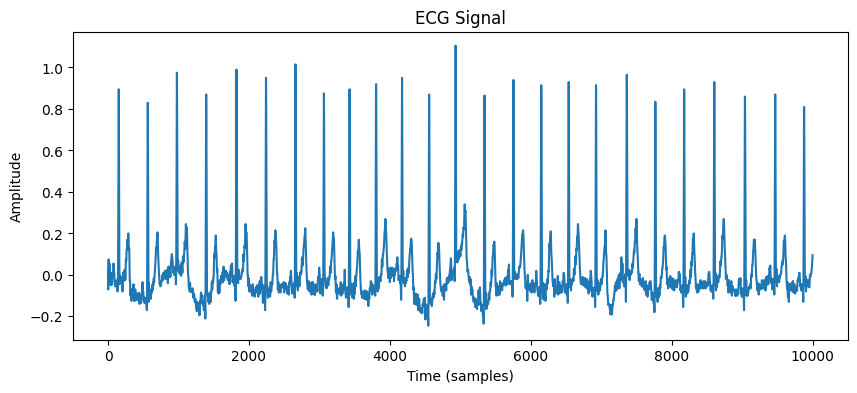

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [29]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
# hr2 = pd.read_csv("file_resource/ecg-id-database-1.0.0/Person_03",names=["hr"])
# print(hr2.head())
# create new datatime index to hr2, every 0.5s

import wfdb
import matplotlib.pyplot as plt

# Specify the path to your downloaded data
path_to_data = 'file_resource/ecg-id-database-1.0.0/Person_03/'

# The record name is the filename without the extension
record_name = 'rec_1'

# Use the 'rdrecord' function to read the ECG data
record = wfdb.rdrecord(f'{path_to_data}/{record_name}')
# Plot the ECG data
plt.figure(figsize=(10, 4))
plt.plot(record.p_signal[:,1])
plt.title('ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()
pd.DataFrame(record.p_signal[:,1],columns=["hr"]).to_csv("./P3_rec_1.csv")
hr2 = pd.DataFrame(record.p_signal[:,1],columns=["hr"])[0:10000]



plt.figure(figsize=(10, 4))



In [30]:

from torch import nn
import pandas as pd
import numpy as np
# X = [x for x in range(10000)]
# hr2_train = hr2[:8000]
# hr2_test = hr2[8000:9000]
# hr2_val = hr2[9000:]
#
# # hr2[0:800].plot()
# train_X = X[:8000]
# test_X = X[8000:9000]
# val_X = X[9000:]
# hr2_train_y = hr2[:8000]
# hr2_test_y = hr2[8000:9000]
# hr2_val_y = hr2[9000:]
df = hr2.copy()
df_train = df.loc[:8000].copy()
df_test = df.loc[8000:10000].copy()

target_sensor = "hr"
# features = list(df.columns.difference([target_sensor]))
features = ["hr"]
forecast_lead = 15
target = f"{target_sensor}_lead{forecast_lead}"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

df_train = df.loc[:8000].copy()
df_test = df.loc[8000:].copy()

print("Test set fraction:", len(df_train) / len(df_test))

target_mean = df_train[target].mean()
target_stdev = df_train[target].std()
for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

Test set fraction: 4.030730478589421


In [31]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]

        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)
            

        return x, self.y[i]

i = 40
sequence_length = 20

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]


In [32]:
X, y = train_dataset[i + 1]

print(X)

tensor([[ 0.1887],
        [ 0.0921],
        [ 0.0276],
        [-0.0369],
        [-0.0369],
        [-0.0046],
        [ 0.0276],
        [ 0.0276],
        [-0.0369],
        [-0.1013],
        [-0.1658],
        [-0.2302],
        [-0.2302],
        [-0.1980],
        [-0.1335],
        [-0.0691],
        [ 0.0276],
        [ 0.0598],
        [ 0.0276],
        [-0.0369]])


In [33]:
print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])


          hr
21  0.285430
22  0.188744
23  0.092058
24  0.027600
25 -0.036857
26 -0.036857
27 -0.004628
28  0.027600
29  0.027600
30 -0.036857
31 -0.101314
32 -0.165772
33 -0.230229
34 -0.230229
35 -0.198000
36 -0.133543
37 -0.069086
38  0.027600
39  0.059829
40  0.027600


In [34]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 20, 1])
tensor([[[-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.5203],
         [-0.4881],
         [-0.4881],
         [-0.4558],
         [-0.4236],
         [-0.3914],
         [-0.3914],
         [-0.4236],
         [-0.4558],
         [-0.4881],
         [-0.5203],
         [-0.5525],
         [-0.5525],
         [-0.5525],
         [-0.5203]],

        [[ 0.9622],
         [ 0.8978],
         [ 0.8655],
         [ 0.8333],
         [ 0.8011],
         [ 0.8333],
         [ 0.8655],
         [ 0.9622],
         [ 1.0589],
         [ 1.1556],
         [ 1.2845],
         [ 1.3812],
         [ 1.4779],
         [ 1.5423],
         [ 1.5746],
         [ 1.5423],
         [ 1.5101],
         [ 1.4457],
         [ 1.3490],
         [ 1.2845]],

        [[-0.0369],
         [-0.0691],
         [-0.0691],
         [-0.1335],
         [-0.1658],
         [-0.1980],
         [-0.1980],
         [-0.1980],
         [-0.

In [35]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 30, 1])
Target shape: torch.Size([4])


In [36]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out
    
class ShallowRegressionRNN(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.rnn = nn.RNN(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, hn = self.rnn(x, h0)
        out = self.linear(hn).flatten()

        return out

In [42]:

num_hidden_units = 64
loss_function = nn.MSELoss()
model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)


In [43]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
# test_model(test_loader, model, loss_function)
print()



Untrained test
--------



In [46]:
learning_rate = 1e-3

optimizer = torch.optim.SGD(model_lstm.parameters(), lr=learning_rate)
for ix_epoch in range(200):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    test_model(test_loader, model_lstm, loss_function)
    print()

Epoch 0
---------
Train loss: 0.4458819785936869
Test loss: 0.5056228760382744

Epoch 1
---------
Train loss: 0.41324207563141907
Test loss: 0.5131649336591132

Epoch 2
---------
Train loss: 0.40458559168837566
Test loss: 0.5073744510443341

Epoch 3
---------
Train loss: 0.3968302154591701
Test loss: 0.5026900022060379

Epoch 4
---------
Train loss: 0.38934395748641115
Test loss: 0.48778125360597324

Epoch 5
---------
Train loss: 0.38451333120102826
Test loss: 0.4741083338968662

Epoch 6
---------
Train loss: 0.377552087539601
Test loss: 0.47879431099705616

Epoch 7
---------
Train loss: 0.372758498498779
Test loss: 0.46590307340483483

Epoch 8
---------
Train loss: 0.36731273269374515
Test loss: 0.46685183341587966

Epoch 9
---------
Train loss: 0.36192655436641563
Test loss: 0.4529162838464669

Epoch 10
---------
Train loss: 0.35700827793728845
Test loss: 0.45422242459344725

Epoch 11
---------
Train loss: 0.3500818920989129
Test loss: 0.4523398890039978

Epoch 12
---------
Train los

KeyboardInterrupt: 

In [47]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model_lstm).numpy()
df_test[ystar_col] = predict(test_loader, model_lstm).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)


      hr_lead15  Model forecast
0        -0.040        0.035947
1        -0.020        0.062231
2         0.005        0.200782
3         0.030        0.271449
4         0.050        0.001651
...         ...             ...
9980      0.065        0.013778
9981      0.070        0.010771
9982      0.080        0.009329
9983      0.085        0.008299
9984      0.095        0.024301

[9986 rows x 2 columns]


In [48]:
# save the model
torch.save(model_lstm.state_dict(), "model_lsmt.pt")


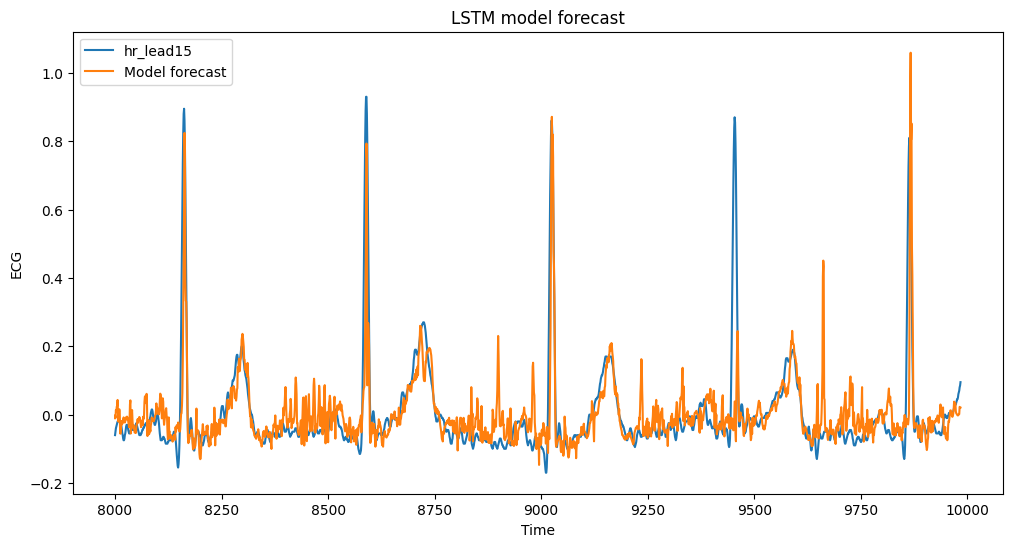

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
df_out[8000:].plot(ax=ax)
ax.set_title("LSTM model forecast")
ax.set_ylabel("ECG")
ax.set_xlabel("Time")
plt.show()

In [49]:
# calculate the  error

from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(df_out[target], df_out[ystar_col])
mae = mean_absolute_error(df_out[target], df_out[ystar_col])
print(f"MAE: {mae:.6f} ")
print(f"RMSE: {np.sqrt(mse):.6f}")

MAE: 0.041441 deg C
RMSE: 0.082949 deg C


In [65]:
num_hidden_units = 128
loss_function = nn.MSELoss()
model = ShallowRegressionRNN(num_sensors=len(features), hidden_units=num_hidden_units)


In [93]:
learning_rate = 1e-7

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for ix_epoch in range(200):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Epoch 0
---------
Train loss: 0.5128665513096974
Test loss: 0.5530596259486336

Epoch 1
---------
Train loss: 0.5130815137763448
Test loss: 0.5530544072848705

Epoch 2
---------
Train loss: 0.5128495385676893
Test loss: 0.5530492860969799

Epoch 3
---------
Train loss: 0.5128508903965148
Test loss: 0.5530457648519971

Epoch 4
---------
Train loss: 0.5128637118380983
Test loss: 0.5530399965896844

Epoch 5
---------
Train loss: 0.516472261772479
Test loss: 0.5530435110553485

Epoch 6
---------
Train loss: 0.5128311162657939
Test loss: 0.5530430078172683

Epoch 7
---------
Train loss: 0.5128165217639675
Test loss: 0.5530381464619345

Epoch 8
---------
Train loss: 0.5128418723413807
Test loss: 0.553034003005282

Epoch 9
---------
Train loss: 0.512820823467482
Test loss: 0.5530324978653203

Epoch 10
---------
Train loss: 0.5128516824620458
Test loss: 0.553030147495955

Epoch 11
---------
Train loss: 0.5129434973960728
Test loss: 0.5530298915371942

Epoch 12
---------
Train loss: 0.512810352

KeyboardInterrupt: 

In [94]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      hr_lead15  Model forecast
0        -0.040        0.074164
1        -0.020        0.029855
2         0.005        0.174612
3         0.030        0.407582
4         0.050        0.533335
...         ...             ...
9980      0.065        0.005950
9981      0.070       -0.016185
9982      0.080       -0.013940
9983      0.085        0.001073
9984      0.095        0.018986

[9986 rows x 2 columns]


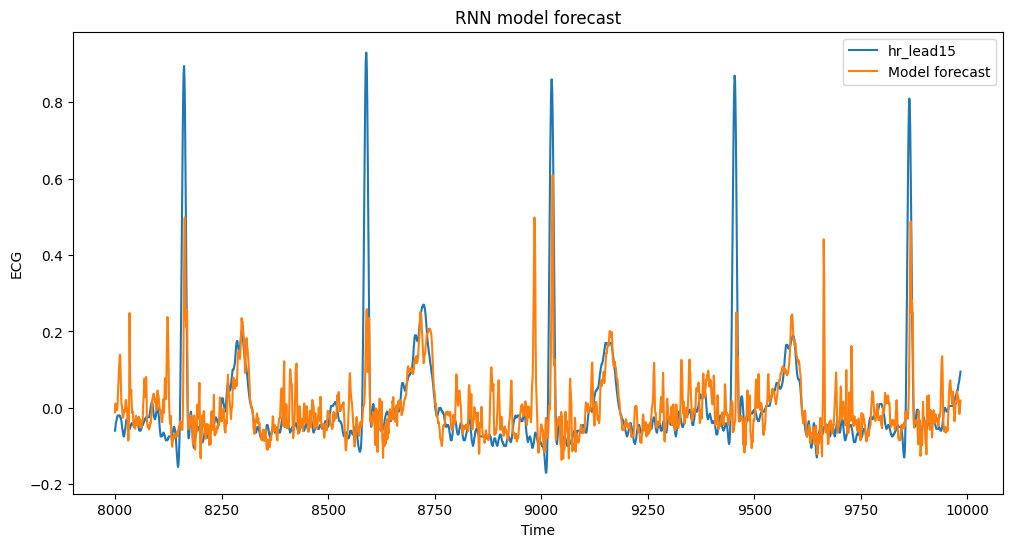

MAE: 0.056574 deg C
RMSE: 0.111980 deg C


In [95]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
df_out[8000:].plot(ax=ax)
ax.set_title("RNN model forecast")
ax.set_ylabel("ECG")
ax.set_xlabel("Time")
plt.show()
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(df_out[target], df_out[ystar_col])
mae = mean_absolute_error(df_out[target], df_out[ystar_col])
print(f"MAE: {mae:.6f} deg C")
print(f"RMSE: {np.sqrt(mse):.6f} deg C")